## Data, Losses, Metrics

In [1]:
from dipeptides.data import SpiceData
root = "data/spice-dipep-dipolar.h5"
cutoff = 4.0
edata = SpiceData(root,cutoff,batch_size=4,in_memory=False,valid_p=0.1,test_p=0)
for batch in edata.train_dataloader():
    exdatabatch = batch
    break
exdatabatch

/home/king1305/.local/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/king1305/.local/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Batch(atomic_numbers=[195], batch=[195], cell=[12, 3], dipole=[4, 3], edge_index=[2, 3166], energy=[4], force=[195, 3], mbi_charges=[195], positions=[195, 3], ptr=[5], shifts=[3166, 3], unit_shifts=[3166, 3])

In [2]:
#Losses
import torch
from cace.tasks import GetLoss
e_loss = GetLoss(
    target_name="energy",
    predict_name='pred_energy',
    loss_fn=torch.nn.MSELoss(),
    loss_weight=1,
)
f_loss = GetLoss(
    target_name="force",
    predict_name='pred_force',
    loss_fn=torch.nn.MSELoss(),
    loss_weight=1000,
)
losses = [e_loss,f_loss]

#Metrics
from cace.tools import Metrics
e_metric = Metrics(
            target_name="energy",
            predict_name='pred_energy',
            name='e',
            metric_keys=["rmse"],
            per_atom=True,
        )
f_metric = Metrics(
            target_name="force",
            predict_name='pred_force',
            metric_keys=["rmse"],
            name='f',
        )
metrics = [e_metric,f_metric]

## SR and LR Model

In [3]:
from cace.tasks import LightningData, LightningTrainingTask
from dipeptides.model import make_cace_lr

#LR model
lr_model = make_cace_lr(cutoff=cutoff,lr=True)
lr_model.cuda()
lr_model(exdatabatch.cuda())
lr_task = LightningTrainingTask(lr_model,losses=losses,metrics=metrics,
                             logs_directory="models/test",name="test",
                             scheduler_args={'mode': 'min', 'factor': 0.8, 'patience': 10},
                             optimizer_args={'lr': 0.01},
                            )
chkpt = "models/lr-model.ckpt"
lr_task.load(chkpt)
lr_task.model.cuda()

#SR model
sr_model = make_cace_lr(cutoff=cutoff,lr=False)
sr_model.cuda()
sr_model(exdatabatch.cuda())
sr_task = LightningTrainingTask(sr_model,losses=losses,metrics=metrics,
                             logs_directory="models/test",name="test",
                             scheduler_args={'mode': 'min', 'factor': 0.8, 'patience': 10},
                             optimizer_args={'lr': 0.01},
                            )
chkpt = "models/sr-model.ckpt"
sr_task.load(chkpt)
sr_task.model.cuda();

Loading model from models/lr-model.ckpt ...
Loading successful!
Loading model from models/sr-model.ckpt ...
Loading successful!


## Charges

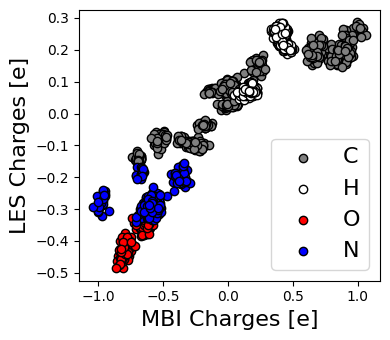

In [6]:
import numpy as np
import matplotlib.pyplot as plt
fac = (90.0474)**0.5

mbi_charges = []
nn_charges = []
atomic_nums = []
for batch in edata.val_dataloader():
    out = lr_task.model(batch.cuda())
    atomic_nums.append(batch["atomic_numbers"].squeeze().cpu().detach().numpy())
    nn_charges.append(out["q"].squeeze().cpu().detach().numpy()/fac)
    mbi_charges.append(batch["mbi_charges"].cpu().detach().numpy())
atomic_nums = np.hstack(atomic_nums)
mbi_charges = np.hstack(mbi_charges)
nn_charges = np.hstack(nn_charges)

fs=16
djvfont = {'fontname':'DejaVu Sans'}
eltrans = {1:"H",6:"C",7:"N",8:"O"}
colors = {1:"white",6:"grey",7:"blue",8:"red"}
plt.subplots(figsize=(4,3.5))
for el in [6,1,8,7]:
    idx = np.where(atomic_nums == el)[0]
    mbi = mbi_charges[idx]
    nnc = nn_charges[idx]
    plt.scatter(mbi,nnc,label=eltrans[el],color=colors[el],edgecolors='black')
plt.xlabel("MBI Charges [e]",fontsize=fs,**djvfont)
plt.ylabel("LES Charges [e]",fontsize=fs,**djvfont)
plt.legend(loc="lower right",prop={'family':'DejaVu Sans', 'size':fs})
plt.tight_layout()

## Dipole Moments

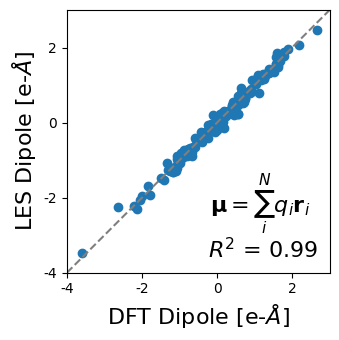

In [7]:
import numpy as np
from cace.tools import scatter_sum
import matplotlib.pyplot as plt
fac = (90.0474)**0.5

mbi_dipole = []
nn_dipole = []
dft_dipole = []
for batch in edata.val_dataloader():
    #NN dipole
    out = lr_task.model(batch.cuda())
    dipole = batch["positions"] * out["q"] / fac
    dipole = scatter_sum(src=dipole, index=batch["batch"], dim=0)
    nn_dipole.append(dipole.cpu().detach().numpy())

    #MBI dipole
    dipole = batch["positions"] * batch["mbi_charges"][:,None]
    dipole = scatter_sum(src=dipole, index=batch["batch"], dim=0)
    mbi_dipole.append(dipole.cpu().detach().numpy())

    #Dipole
    dft_dipole.append(batch["dipole"].cpu().detach().numpy())

#Dipoles
nn_dipole = np.vstack(nn_dipole).ravel()
mbi_dipole = np.vstack(mbi_dipole).ravel()
dft_dipole = np.vstack(dft_dipole).ravel()

from sklearn.metrics import r2_score
djvfont = {'fontname':'DejaVu Sans'}
r2 = np.round(r2_score(dft_dipole,nn_dipole),2)
plt.subplots(figsize=(4,3.5))
plt.scatter(dft_dipole,nn_dipole)
fs=16
plt.xlabel("DFT Dipole [e-$\AA$]",fontsize=fs,**djvfont)
plt.ylabel("LES Dipole [e-$\AA$]",fontsize=fs,**djvfont)
x = y = np.arange(-4,3.5)
plt.plot(x,y,linestyle="--",color="grey")
plt.xlim(-4,3)
plt.ylim(-4,3)
s = 2
plt.xticks(np.arange(-4,4,s),np.arange(-4,4,s))
plt.yticks(np.arange(-4,4,s),np.arange(-4,4,s))
plt.text(-0.2,-2.4,"$\mathbf{\mu} = \sum_i^N q_i \mathbf{r}_{i}$",fontsize=fs,**djvfont)
plt.text(-0.25,-3.6,f"$R^2$ = {r2}",fontsize=fs,**djvfont)
# "+"={r2}$")
plt.gca().set_aspect('equal')
plt.tight_layout()

In [8]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(dft_dipole,nn_dipole)

0.0890832

In [9]:
mean_absolute_error(dft_dipole,mbi_dipole)

0.06337994

## Performance on Test Set

In [10]:
from dipeptides.data import SpiceData
import pandas as pd
root = "data/spice-dipep-dipolar-test.h5"
cutoff = 4.0
edata_test = SpiceData(root,cutoff,batch_size=1000,in_memory=True,valid_p=0,test_p=1)
df = pd.DataFrame()
for batch in edata_test.test_dataloader():
    lr_out = lr_task.model(batch.cuda())
    sr_out = sr_task.model(batch.cuda())
    df.loc["E","CACE-LR test"] = e_metric(lr_out,batch)["rmse"].item()
    df.loc["F","CACE-LR test"] = f_metric(lr_out,batch)["rmse"].item()
    df.loc["E","CACE-SR test"] = e_metric(sr_out,batch)["rmse"].item()
    df.loc["F","CACE-SR test"] = f_metric(sr_out,batch)["rmse"].item()
df

,CACE-LR test,CACE-SR test
E,0.001878,0.002354
F,0.061126,0.072430
